In [18]:
import numpy as np
import pandas as pd


from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from psql_functions import execQuery
from miss_data import add_missing_dates, add_missing_counts
from make_plots import dict_error_plot_epsilons, dict_error_plot_n

import warnings
warnings.filterwarnings('ignore')

import sys
import os
import re
owd = os.getcwd()
from scipy import stats


In [2]:
param_dic = {
    "host"      : "localhost",
    "database"  : "bachelorBesoeg2014",
    "user"      : "postgres",
    "password"  : "password",
    "port"      : "5432"
}

query = """select time_ from _775147;"""
result = execQuery(param_dic, query)
dates = [(date[0]) for date in result]

query = """select count_ from _775147;"""
result = execQuery(param_dic, query)

counts = [(count[0]) for count in result]

all_dates = add_missing_dates(dates)
all_counts =  add_missing_counts(counts, dates, all_dates)

n_data_structures = 50


In [3]:
onlydirs = [f for f in os.listdir(os.getcwd()) if os.path.isdir(os.path.join(os.getcwd(), f)) and f[0] != '.']

In [4]:
onlydirs

['plots', 'range_queries', 'results', '__pycache__']

In [5]:
def make_lookup_error_dict_e_n(epsilons, n):
    epsilon_dict = dict.fromkeys(epsilons)
    n_dicts = []
    for i in range(0,len(epsilons)):
        n_dict = dict.fromkeys(n)
        n_dicts.append(n_dict)

    i = 0
    for e_key in epsilon_dict:
        epsilon_dict[e_key] = n_dicts[i]
        i = i + 1
    return epsilon_dict

def make_query_lookup_dict_n_r(n, rs):
    n_dict = dict.fromkeys(n)
    r_dicts = []
    for i in range(0,len(n)):
        #print(rs[i])
        r_dict = dict.fromkeys(rs[i])
        r_dicts.append(r_dict)

    for idx, n_key in enumerate(n_dict):
            n_dict[n_key] = r_dicts[idx]
    
    return n_dict

def fill_up_query_lookup_dict_n_r(n, rs, path, files):
    dict_ = make_query_lookup_dict_n_r(n, rs)
    for idx, f in enumerate(files):
        here_n = re.search(r'N=\d+', f).group(0)
        here_n = here_n.split("N=")[1]
        here_r = re.search(r'r=\d+', f).group(0) 
        here_r = here_r.split("r=")[1]
        
        querries = load_range_queries_n_split(path + f, n_data_structures)
        dict_[int(here_n)][int(here_r)] = querries.copy()
    return dict_

In [6]:
def make_lookup_error_dict(epsilons, n, rs):
    epsilon_dict = dict.fromkeys(epsilons)
    n_dicts = []
    for i in range(0,len(epsilons)):
        n_dict = dict.fromkeys(n)
        n_dicts.append(n_dict)
    r_dicts = []
    for i in range(0,len(n)*len(epsilons)):
        r_dict = dict.fromkeys(rs[i%len(n)])
        r_dicts.append(r_dict)
    i = 0
    j = 0
    for e_key in epsilon_dict:
        epsilon_dict[e_key] = n_dicts[i]
        n_dict = epsilon_dict[e_key]
        for n_key in n_dict:
            #print(j)
            n_dict[n_key] = r_dicts[j]
            j = j + 1
        i = i + 1
    return epsilon_dict


def fill_up_lookup_error_dict(epsilons, n, degrees, path, files):
    dict_ = make_lookup_error_dict(epsilons, n, degrees)
    for idx, f in enumerate(files):
        #print(f)
        e = re.search(r'e=[-+]?[0-9]*\.?[0-9]*', f).group(0)
        e = e.split("e=")[1]
        here_n = re.search(r'N=\d+', f).group(0)
        here_n = here_n.split("N=")[1]
        here_r = re.search(r'r=\d+', f).group(0) 
        here_r = here_r.split("r=")[1]

        dict_[float(e)][int(here_n)][int(here_r)] = np.loadtxt(path + f, delimiter=',')
    return dict_

def find_error_different_queries(est, cor):
    erorrs = est - cor
    max_error = np.amax(erorrs)
    min_error = np.amin(erorrs)
    rmse = mean_squared_error(cor, est, squared = False)
    error_dict = {'rmse': rmse, 'max': max_error, 'min': min_error, 'abs': np.mean(erorrs)}
    return error_dict

In [7]:
epsilons = np.array([2, 1.4, 1.2, 1, 0.8, 0.6, 0.4, 0.2])
n = np.array([32,128,256,512,1024,2048])
r_32 =  np.array([2, 4, 8, 12, 16, 20, 24])
r_128 =  np.array([20, 40, 50, 60, 70, 80, 90])
r_256 =  np.array([40, 60, 80, 100, 140, 200, 220])
r_512 =  np.array([100, 150, 200, 250, 300, 400, 450])
r_1024 =  np.array([200, 300, 400, 500, 600, 800, 900])
r_2048 =  np.array([600, 800, 1000, 1250, 1500, 1700, 1800])

rs =  [r_32, r_128, r_256, r_512, r_1024, r_2048]

In [8]:
len(epsilons)*len(n)*len(rs[0])

336

# Loading the data 

In [9]:
path =  owd +'/'+'results/sample_querys/central_flat/flat_varying_r/'
files = os.listdir(path)
files_cor = files[:len(files)//2]
files_est = files[len(files)//2:]
print(files_cor)
print(len(files_cor))

print(files_est)
print(len(files_est))
"""
#Where flat beats hh
hh_files_cor_flat = hh_files_cor[:144]
#Where hh beats flat
hh_files_cor_hh = hh_files_cor[144+1:]
#print(hh_files_cor_flat)
#print(hh_files_cor_hh)
hh_files_est = hh_files[len(hh_files)//2:]
hh_files_est_flat = hh_files_est[:144]
hh_files_est_hh = hh_files_est[144+1:]
#print(hh_files_est_flat)
#print(hh_files_est_hh)
"""

['cor_e=0.2_N=1024_r=200.csv', 'cor_e=0.2_N=1024_r=300.csv', 'cor_e=0.2_N=1024_r=400.csv', 'cor_e=0.2_N=1024_r=500.csv', 'cor_e=0.2_N=1024_r=600.csv', 'cor_e=0.2_N=1024_r=800.csv', 'cor_e=0.2_N=1024_r=900.csv', 'cor_e=0.2_N=128_r=20.csv', 'cor_e=0.2_N=128_r=40.csv', 'cor_e=0.2_N=128_r=50.csv', 'cor_e=0.2_N=128_r=60.csv', 'cor_e=0.2_N=128_r=70.csv', 'cor_e=0.2_N=128_r=80.csv', 'cor_e=0.2_N=128_r=90.csv', 'cor_e=0.2_N=2048_r=1000.csv', 'cor_e=0.2_N=2048_r=1250.csv', 'cor_e=0.2_N=2048_r=1500.csv', 'cor_e=0.2_N=2048_r=1700.csv', 'cor_e=0.2_N=2048_r=1800.csv', 'cor_e=0.2_N=2048_r=600.csv', 'cor_e=0.2_N=2048_r=800.csv', 'cor_e=0.2_N=256_r=100.csv', 'cor_e=0.2_N=256_r=140.csv', 'cor_e=0.2_N=256_r=200.csv', 'cor_e=0.2_N=256_r=220.csv', 'cor_e=0.2_N=256_r=40.csv', 'cor_e=0.2_N=256_r=60.csv', 'cor_e=0.2_N=256_r=80.csv', 'cor_e=0.2_N=32_r=12.csv', 'cor_e=0.2_N=32_r=16.csv', 'cor_e=0.2_N=32_r=2.csv', 'cor_e=0.2_N=32_r=20.csv', 'cor_e=0.2_N=32_r=24.csv', 'cor_e=0.2_N=32_r=4.csv', 'cor_e=0.2_N=32_r=

'\n#Where flat beats hh\nhh_files_cor_flat = hh_files_cor[:144]\n#Where hh beats flat\nhh_files_cor_hh = hh_files_cor[144+1:]\n#print(hh_files_cor_flat)\n#print(hh_files_cor_hh)\nhh_files_est = hh_files[len(hh_files)//2:]\nhh_files_est_flat = hh_files_est[:144]\nhh_files_est_hh = hh_files_est[144+1:]\n#print(hh_files_est_flat)\n#print(hh_files_est_hh)\n'

In [10]:
cor_dict = fill_up_lookup_error_dict(epsilons, n, rs, path, files_cor)
est_dict = fill_up_lookup_error_dict(epsilons, n, rs, path, files_est)


In [11]:
cor_dict

{2.0: {32: {2: array([254., 655., 631., ..., 265., 265., 631.]),
   4: array([488., 649., 703., ..., 404., 859., 472.]),
   8: array([1562., 1540., 1274., ..., 1594., 1683., 1562.]),
   12: array([2521., 2419., 2219., ..., 2348., 2406., 2602.]),
   16: array([2987., 3093., 2987., ..., 3224., 3250., 3369.]),
   20: array([4018., 3628., 3857., ..., 3628., 3932., 4108.]),
   24: array([4524., 4638., 4506., ..., 4414., 4414., 4882.])},
  128: {20: array([3198., 3884., 4474., ..., 4293., 4725., 5515.]),
   40: array([10073.,  7950.,  9506., ...,  8825.,  8877.,  7819.]),
   50: array([12174., 12384., 11825., ..., 11333., 10904., 10833.]),
   60: array([12846., 12981., 12846., ..., 12897., 13035., 12245.]),
   70: array([16106., 15141., 15221., ..., 15388., 14724., 15111.]),
   80: array([17007., 16874., 18496., ..., 17050., 18253., 18000.]),
   90: array([20217., 19108., 19300., ..., 20087., 19342., 19282.])},
  256: {40: array([6979., 7128., 6701., ..., 7006., 8049., 5961.]),
   60: array(

In [12]:
est_dict

{2.0: {32: {2: array([254.77304582, 657.05864617, 629.82690733, ..., 265.13557587,
          265.13557587, 631.46176431]),
   4: array([487.6488765 , 649.05748571, 703.21352885, ..., 405.03239141,
          859.6840709 , 471.44716806]),
   8: array([1560.83312221, 1540.43582204, 1272.34409975, ..., 1595.72039593,
          1683.78515115, 1562.24081442]),
   12: array([2521.13978503, 2419.85813541, 2219.9433602 , ..., 2349.86838985,
          2406.82440481, 2603.49935892]),
   16: array([2987.25439772, 3092.78201947, 2987.25439772, ..., 3224.375987  ,
          3251.61845166, 3369.25748042]),
   20: array([4020.98497097, 3627.76586474, 3859.57636175, ..., 3629.40837841,
          3934.31046714, 4109.50493058]),
   24: array([4525.06681299, 4639.80149561, 4508.63384746, ..., 4417.03595384,
          4417.03595384, 4883.70258473])},
  128: {20: array([3198.1512956 , 3884.26068047, 4469.99866067, ..., 4292.50144325,
          4723.81763943, 5507.36851426]),
   40: array([10065.59210158,  7

In [13]:
error_dict = make_lookup_error_dict(epsilons, n, rs)

for e in epsilons:
    for N in n:
        #r_values = error_dict[e][N]
        for r in error_dict[e][N]:
            error_dict[e][N][r] = find_error_different_queries(est_dict[e][N][r], cor_dict[e][N][r])

In [14]:
dict_plot_rmse_dict = make_lookup_error_dict_e_n(epsilons, n)
for e in epsilons:
    for N in n:
        rmse = []
        for r_keys in error_dict[e][N]: 
            rmse.append(error_dict[e][N][r_keys]['rmse'])
        
        dict_plot_rmse_dict[e][N] = rmse

In [15]:
def plot(xs, ys, N, epsilon, plot_name):

    plt.scatter(xs, ys)
    #plt.hlines(np.mean(answears128),line_range[0],line_range[1])
    #plt.hlines(np.mean(correct_answear),line_range[0],line_range[1])
    #plt.legend()
    plt.xlabel('Length of query')
    plt.ylabel('RMSE')
    plt.title(f'Flat OLH with N = {N} and \u03B5 = {epsilon}')
    #plt.savefig(plot_name,bbox_inches='tight')
    plt.show()
    
def generate_plots(error_dict):
    for e in epsilons:
        for N in n:
            xs = list(error_dict[e][N].keys())
            #print(xs)
            ys = dict_plot_rmse_dict[e][N]
            #print(ys)
            plot(xs, ys, N, e, 'e')

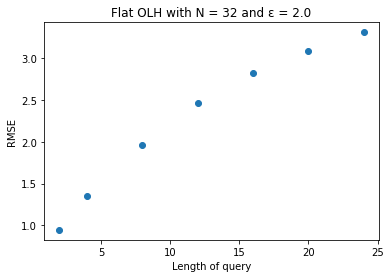

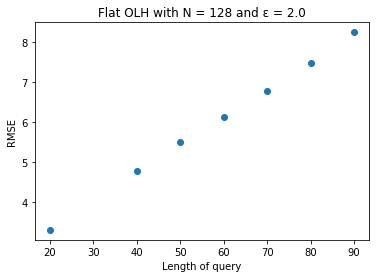

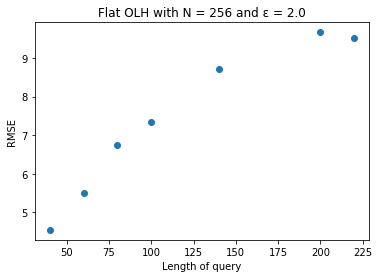

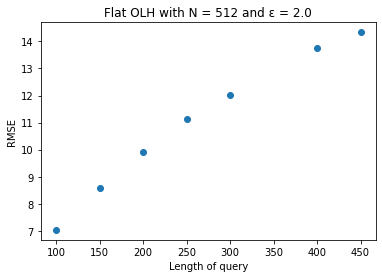

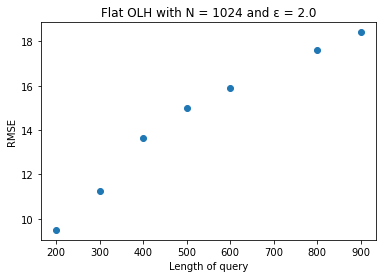

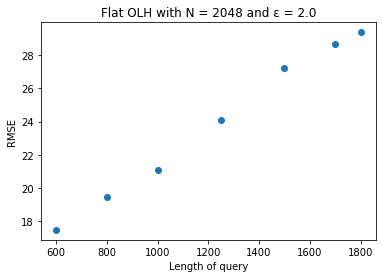

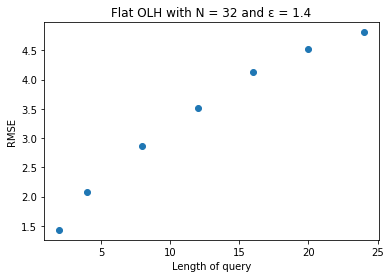

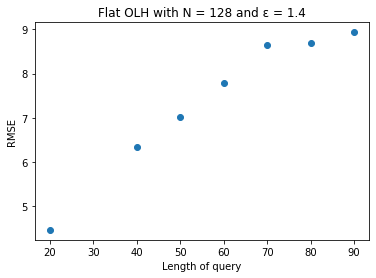

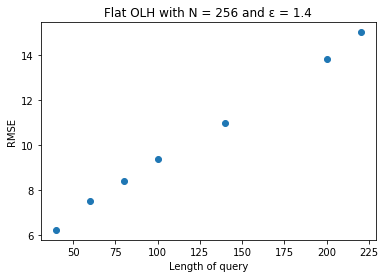

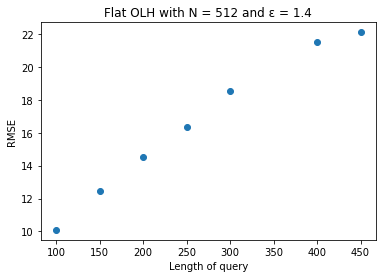

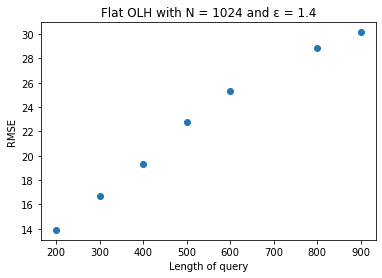

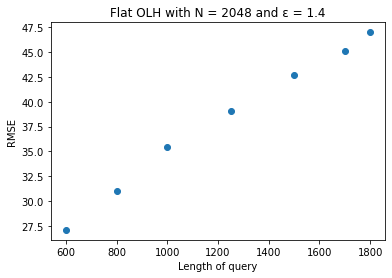

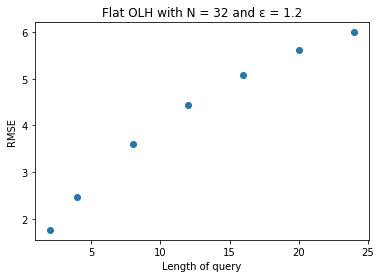

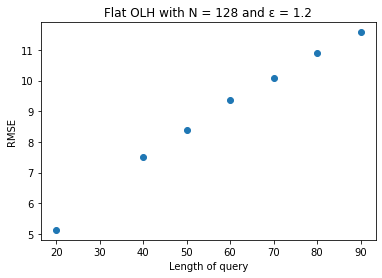

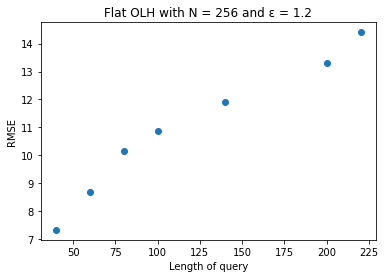

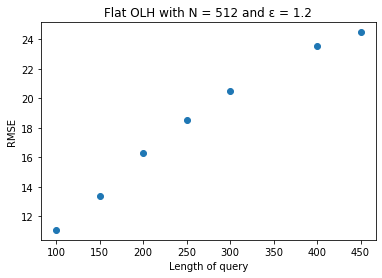

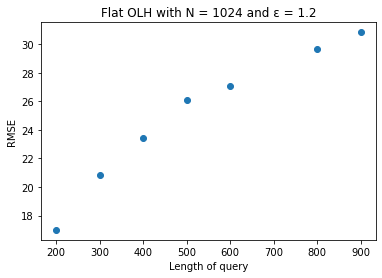

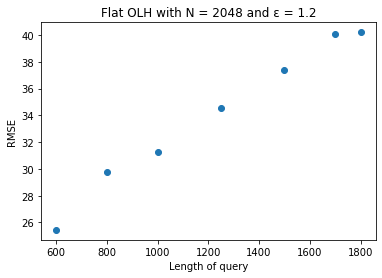

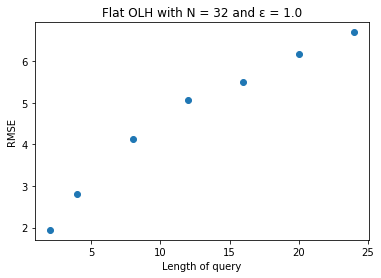

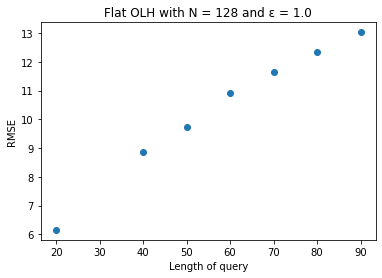

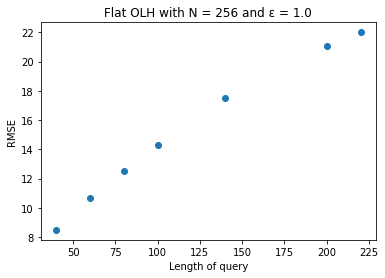

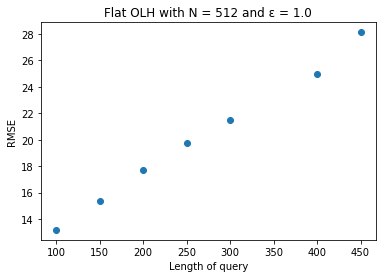

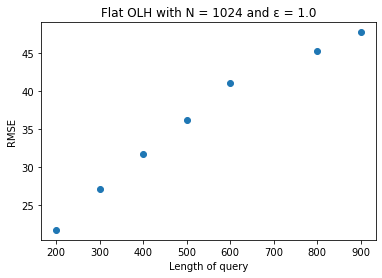

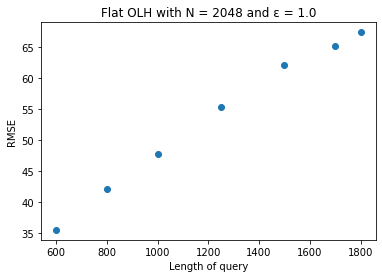

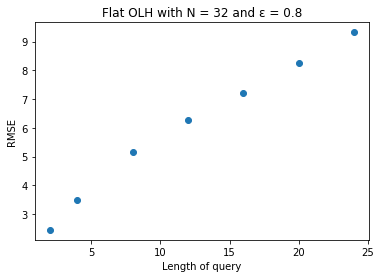

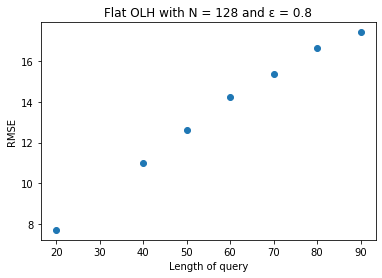

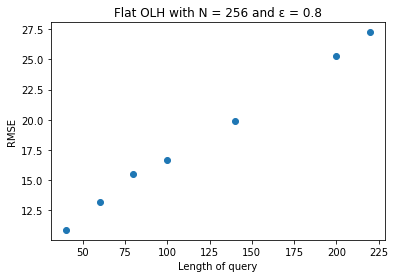

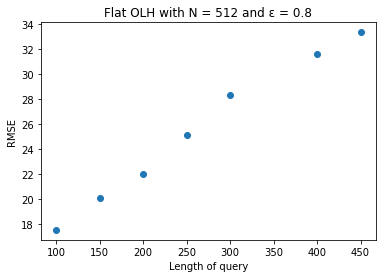

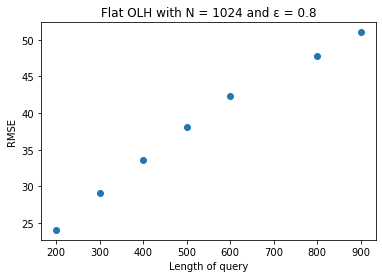

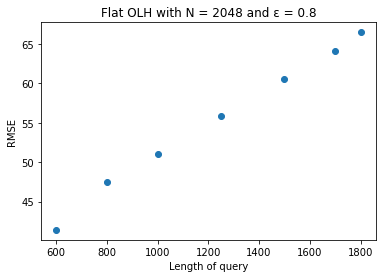

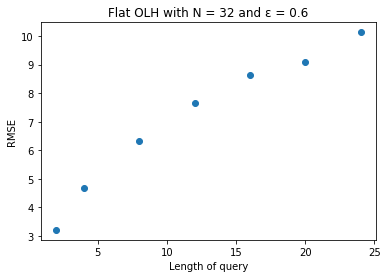

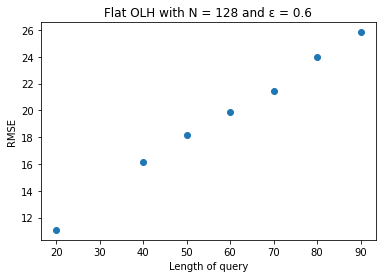

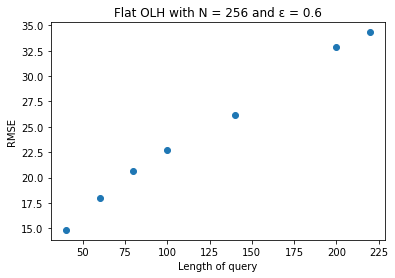

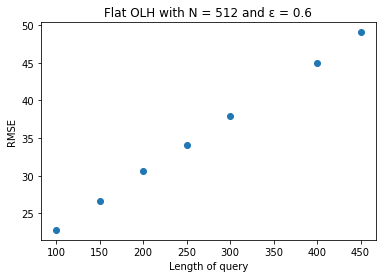

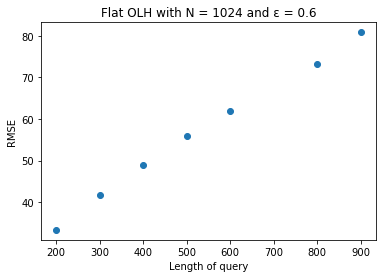

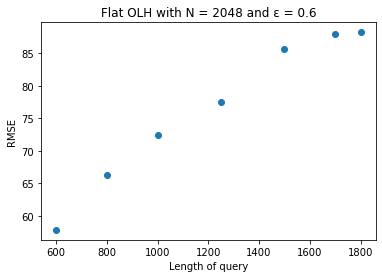

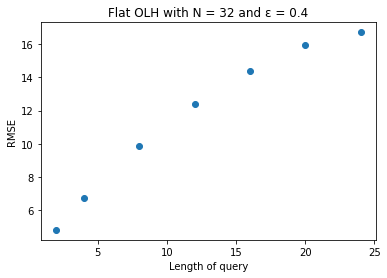

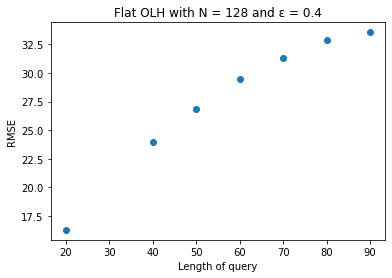

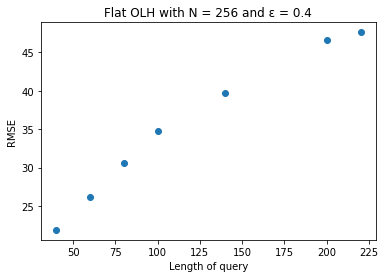

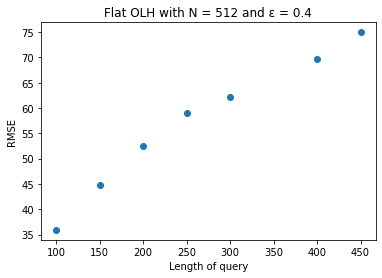

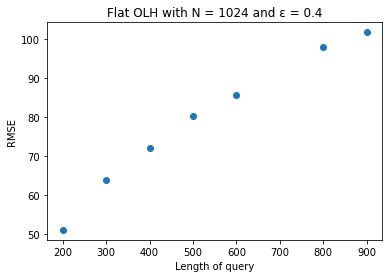

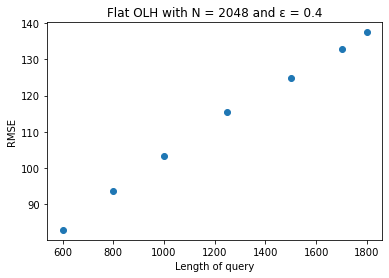

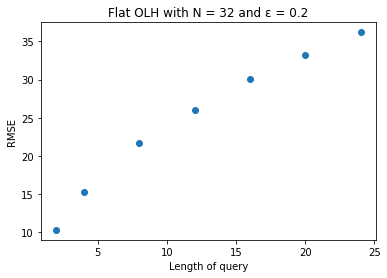

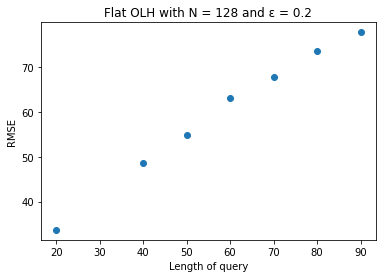

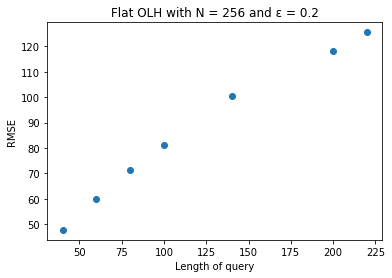

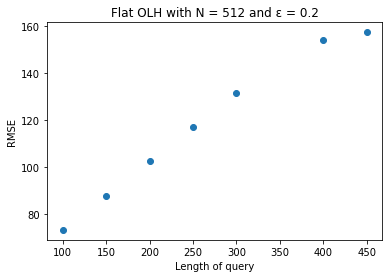

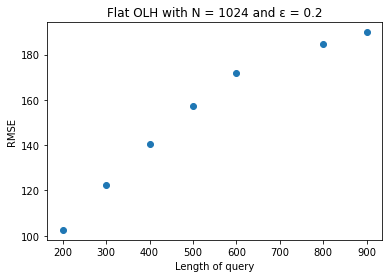

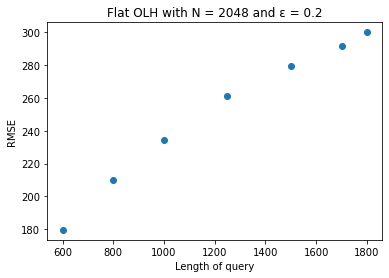

In [16]:
generate_plots(error_dict)


0.9797727848581499
0.981780256389189
0.9811412655283955
0.9766229048682228
0.9922475699706537
0.9755813087275842
0.9802274784190876


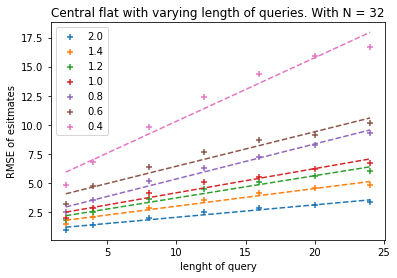

0.9996060761806363
0.9720785216370417
0.9942526957348664
0.9895039716803311
0.993957482811743
0.9971668176808903
0.9723648813591859


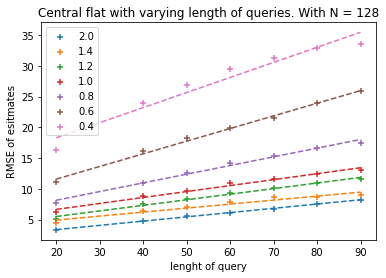

0.9581231015920688
0.9988376499000765
0.976453943500974
0.9932568663222971
0.9983039759635747
0.9970429850489977
0.9855066225830809


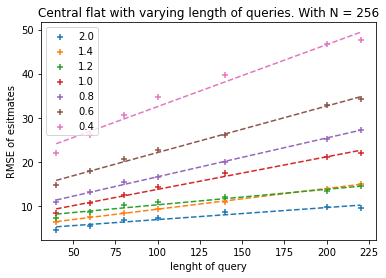

0.989242881077092
0.9910566316149905
0.9880635961040846
0.9975453826552011
0.9943208153861658
0.9998442459804582
0.9826501900081432


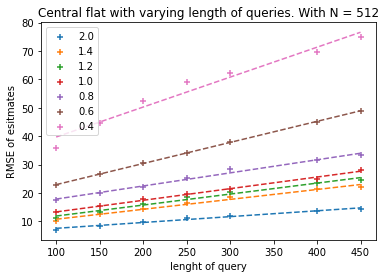

0.9755344463569277
0.9905725767786148
0.9689603481106039
0.9847786558390739
0.993080238534755
0.9980423124039934
0.9866338494139708


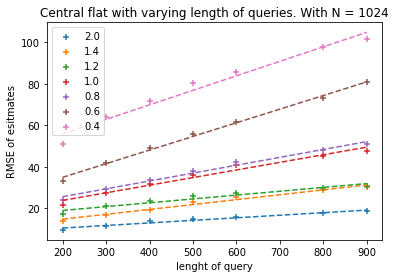

0.9974113206107119
0.9959131865569791
0.9932772760694584
0.9958153106275549
0.9973954018995403
0.9853829771040228
0.9982291147643121


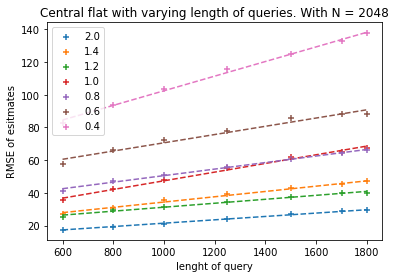

In [19]:
def multi_e_plots(epsilons, n, error_dict, path):
    for N in n:
        rmse_lst = []
        
        for e in epsilons:

            for r_ in error_dict[e][N]:
                rmse = error_dict[e][N][r_]['rmse']
                rmse_lst.append(rmse)
        #print(rmse_lst)
        
        for i in range(len(error_dict[e][N])):
            #print(i)
            #print(list(error_dict[e][N].keys()))
            #print(rmse_lst[i*len(error_dict[e][N]):(i+1)*len(error_dict[e][N])])
            ys = rmse_lst[i*len(error_dict[e][N]):(i+1)*len(error_dict[e][N])]
            xs = list(error_dict[e][N].keys())
            gradient, intercept, r_value, p_value, std_err = stats.linregress(xs,ys)
            mn=np.min(xs)
            mx=np.max(xs)
            x1=np.linspace(mn,mx,500)
            y1=gradient*x1+intercept
            print(r_value)
            #plt.plot(x,y,'ob')
            plt.plot(x1,y1,'--')
            """
            """
            plt.scatter(xs, ys, marker = '+', label=f"{epsilons[i]}")
        #plt.scatter(epsilons, rmse_degree2, marker = '+', label=f"RMSE of HH esitmates")
        
        #plt.yscale('log')
        plt.legend()
        plt.xlabel('lenght of query')
        plt.ylabel('RMSE of esitmates')
        plt_name = f'cen_flat_varying_length_N={N}'
        plt.title(f'Central flat with varying length of queries. With N = {N}')
        #plt.savefig(owd + path + plt_name, bbox_inches='tight')
        plt.show()

path = '/plots/central_flat/varying_r/'
multi_e_plots(epsilons, n, error_dict, path)
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 

x = np.array([1.5,2,2.5,3,3.5,4,4.5,5,5.5,6])
y = np.array([10.35,12.3,13,14.0,16,17,18.2,20,20.7,22.5])
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x,y,'ob')
plt.plot(x1,y1,'-r')
plt.show()